In [49]:
import csv
import os
import sys
import random
import math
import string
import numpy as np
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rc
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql import SQLContext
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, size, max, abs

# Initialize a spark session
spark = SparkSession \
    .builder \
    .appName("Veracity Detection") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# matplotlib inline backend
%matplotlib inline

## Data Preprocessing 
- Data sampling 
- Data cleaning 
- Data preparation and formatting
- Feature extraction

#### Imbalanced Sampling of Data

In [50]:
# Label the datasets, remove unncessary fields, sample and save the samples
random_state=123
# This imbalanced sample will favor the fake label with a ratio of 2 to 1
fake = pd.read_csv('../data/Fake.csv')
fake['label'] = 'Fake'
fake = fake.drop(columns=['date', 'subject'])
fake = fake.sample(4211, random_state=random_state)
true = pd.read_csv('../data/True.csv')
true['label'] = 'True'
true = true.drop(columns=['date', 'subject'])
true = true.sample(2009, random_state=random_state)

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Imbalanced_Sample1_Fake.csv", index=False, header=None)
# true.to_csv("../data/Imbalanced_Sample1_True.csv", index=False, header=None)

# This imbalanced sample will favor the fake label with a ratio of 2 to 1
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(21052, random_state=random_state)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(10049, random_state=random_state)

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Imbalanced_Sample2_Fake.csv", index=False, header=None)
# true.to_csv("../data/Imbalanced_Sample2_True.csv", index=False, header=None)

# This imbalanced sample favors the true label with ratio of 2 to 1
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(10534, random_state=random_state)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(20091, random_state=random_state)

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Imbalanced_Sample3_Fake.csv", index=False, header=None)
# true.to_csv("../data/Imbalanced_Sample3_True.csv", index=False, header=None)

# All the data with imbalance of ~10% favoring fake class
fake = pd.read_csv('../data/Fake.csv')
fake['label'] = 'Fake'
fake = fake.drop(columns=['date', 'subject'])
true = pd.read_csv('../data/True.csv')
true['label'] = 'True'
true = true.drop(columns=['date', 'subject'])

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Imbalanced_Sample4_Fake.csv", index=False, header=None)
# true.to_csv("../data/Imbalanced_Sample4_True.csv", index=False, header=None)

#### Balanced Sampling of Data

In [51]:
# Label the datasets, remove unncessary fields, sample and save the samples

# 10% balanced sample
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(3152, random_state=random_state)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(3016, random_state=random_state)

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Balanced_Sample1_Fake.csv", index=False, header=None)
# true.to_csv("../data/Balanced_Sample1_True.csv", index=False, header=None)

fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(15800, random_state=random_state)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(15067, random_state=random_state)

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Balanced_Sample2_Fake.csv", index=False, header=None)
# true.to_csv("../data/Balanced_Sample2_True.csv", index=False, header=None)

# Largest(~ 42000) balanced sample
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(22107, random_state=random_state)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(21092, random_state=random_state)

# Uncomment and run the cell to save the sample
# fake.to_csv("../data/Balanced_Sample3_Fake.csv", index=False, header=None)
# true.to_csv("../data/Balanced_Sample3_True.csv", index=False, header=None)

#### Collecting Stop Words
Stop words were extracted from nltk, python string module and the articles themselves

In [52]:
with open('../data/stop_punc.txt', 'r') as file:
    stop_punc = file.read()
stop_punc = stop_punc.split(',')
stop_punc = list(set(stop_punc))
stop_punc.append(',')

#### Data Cleaning and Formatting

In [83]:
fake_file = '../data/Imbalanced_Sample2_Fake.csv'
true_file = '../data/Imbalanced_Sample2_True.csv'

# Filtering datapoints with missing features
fake_rdd = spark.read.csv(fake_file).rdd
fake_rdd = fake_rdd.filter(lambda x: x[0] is not None and x[1] is not None).map(lambda x: (x[0] + ' ' + x[1], x[2])).filter(lambda x: x[1]=='Fake')
n_fake = fake_rdd.count()
true_rdd = spark.read.csv(true_file).rdd
true_rdd = true_rdd.filter(lambda x: x[0] is not None and x[1] is not None).map(lambda x: (x[0] + ' ' + x[1], x[2])).filter(lambda x: x[1]=='True')
n_true = true_rdd.count()

# Tokenizing articles and removing stop words from the article
tokenizer = Tokenizer(inputCol="article", outputCol="words")
fake_rdd = fake_rdd.map(lambda x: Row(article=x[0], label=x[1]))
fake_df = spark.createDataFrame(fake_rdd)
fake_df = tokenizer.transform(fake_df)
fake_rdd = fake_df.rdd.map(lambda x: (x[0], [i for i in x[2] if i not in stop_punc], x[1]))
true_rdd = true_rdd.map(lambda x:Row(article=x[0], label=x[1]))
true_df = spark.createDataFrame(true_rdd)
true_df = tokenizer.transform(true_df)
true_rdd = true_df.rdd.map(lambda x: (x[0], [i for i in x[2] if i not in stop_punc], x[1]))

#### Feature Extraction Using TFIDF

In [84]:
n_features = 10

fake_rdd = fake_rdd.map(lambda x: (x[1], x[2])).map(lambda x: Row(words=x[0], label=x[1]))
fake_df = spark.createDataFrame(fake_rdd)
hashingTF = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=n_features)
fake_df = hashingTF.transform(fake_df)
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(fake_df)
fake_df = idfModel.transform(fake_df)
fake_rdd = fake_df.rdd.map(lambda x: (x[3], x[1])).map(lambda x: ([np.take(x[0], i) for i in range(np.size(x[0]))], x[1]))

true_rdd = true_rdd.map(lambda x: (x[1], x[2])).map(lambda x: Row(words=x[0], label=x[1]))
true_df = spark.createDataFrame(true_rdd)
hashingTF = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=n_features)
true_df = hashingTF.transform(true_df)
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(true_df)
true_df = idfModel.transform(true_df)
true_rdd = true_df.rdd.map(lambda x: (x[3], x[1])).map(lambda x: ([np.take(x[0], i) for i in range(np.size(x[0]))], x[1]))


fake = fake_rdd.collect()
true = true_rdd.collect()

### Defining Training and Test Sets Using KFold Cross Validation
Only run one of the two cells below

In [64]:
# Defining folds with stratification
stratification = True
kf = KFold(n_splits=5, shuffle=True, random_state=123)
fake_data = []
for train_index, test_index in kf.split(fake):
    train = []
    test = []
    for i in train_index:
        train.append(fake[i])
    for i in test_index:
        test.append(fake[i])
    fake_data.append((train, test))
true_data = []
for train_index, test_index in kf.split(true):
    train = []
    test = []
    for i in train_index:
        train.append(true[i])
    for i in test_index:
        test.append(true[i])
    true_data.append((train, test))
data = []
for i in range(len(fake_data)):
    true_data[i][0].extend(fake_data[i][0])
    true_data[i][1].extend(fake_data[i][1])
data = true_data

In [85]:
# Defining folds without stratification
stratification = False
fake.extend(true)
random.seed(123)
random.shuffle(fake)
fake_true = fake
data = []
kf = KFold(n_splits=5, shuffle=True, random_state=123)
for train_index, test_index in kf.split(fake_true):
    train = []
    test = []
    for i in train_index:
        train.append(fake_true[i])
    for i in test_index:
        test.append(fake_true[i])
    data.append((train, test))

### Classification Using KNN Classifier

In [86]:
k = int(math.sqrt(n_fake + n_true))
knnc = KNeighborsClassifier(n_neighbors=k)
knn_accuracy = []
knn_predict = []
knn_f1 = []
for i in range(len(data)):
    knnc.fit([j[0] for j in data[i][0]], [j[1] for j in data[i][0]])
    knn_accuracy.append(knnc.score([j[0] for j in data[i][1]], [j[1] for j in data[i][1]]))
    knn_predict.append(knnc.predict([j[0] for j in data[i][1]]))
for i in range(len(knn_predict)):
    knn_f1.append(f1_score([j[1] for j in data[i][1]], knn_predict[i].tolist(), pos_label="True"))
knn_average_f1 = sum(knn_f1)/len(knn_f1)

# KNN Result
print('Classification of', n_fake + n_true, 'datapoints containing')
print(n_fake, 'fake datapoints')
print(n_true, 'true datapoints')
if stratification:
    print('With stratification', end = ' ')
else:
    print('Without stratificaiton', end = ' ')
print('Using,', k, 'NN classifier and 5fold cross validation resulted in average f1 score of', knn_average_f1)

Classification of 30000 datapoints containing
20000 fake datapoints
10000 true datapoints
Without stratificaiton Using, 173 NN classifier and 5fold cross validation resulted in average f1 score of 0.9675079005413387


In [87]:
sum(knn_accuracy)/5

0.9776333333333334

In [88]:
knn_f1

[0.9642156862745099,
 0.9654834761321909,
 0.972579471002184,
 0.9609018949388344,
 0.9743589743589743]

### Classification Using Random Forest Classifier

In [89]:
n_trees = 45
max_depth = 20
rfc = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, random_state=123)
rf_accuracy = []
rf_predict = []
rf_f1 = []
for i in range(len(data)):
    rfc.fit([j[0] for j in data[i][0]], [j[1] for j in data[i][0]])
    rf_accuracy.append(rfc.score([j[0] for j in data[i][1]], [j[1] for j in data[i][1]]))
    rf_predict.append(rfc.predict([j[0] for j in data[i][1]]))
for i in range(len(rf_predict)):
    rf_f1.append(f1_score([j[1] for j in data[i][1]], rf_predict[i].tolist(), pos_label="True"))
rf_average_f1 = sum(rf_f1)/len(rf_f1)

# Result
print('Classification of', n_fake + n_true, 'datapoints containing: ')
print(n_fake, 'fake datapoints')
print(n_true, 'true datapoints')
if stratification:
    print('With stratification', end = ' ')
else:
    print('Without stratificaiton', end = ' ')
print('Using random forest classifier with', n_trees, 'trees, max depth of', max_depth, 'and 5fold cross validation resulted in average f1 score of', rf_average_f1)

Classification of 30000 datapoints containing: 
20000 fake datapoints
10000 true datapoints
Without stratificaiton Using random forest classifier with 45 trees, max depth of 20 and 5fold cross validation resulted in average f1 score of 0.9997033890760504


In [90]:
sum(rf_accuracy)/5

0.9998000000000001

In [91]:
rf_f1

[1.0, 0.999746514575412, 0.9995012468827931, 1.0, 0.9992691839220462]

### Plots

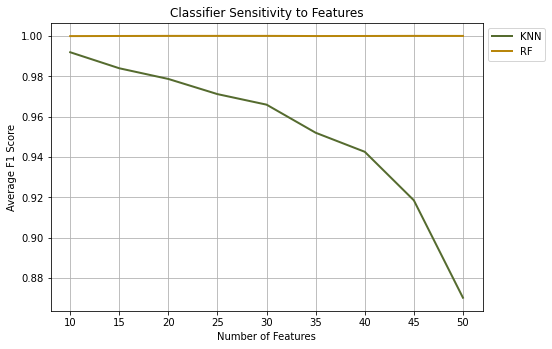

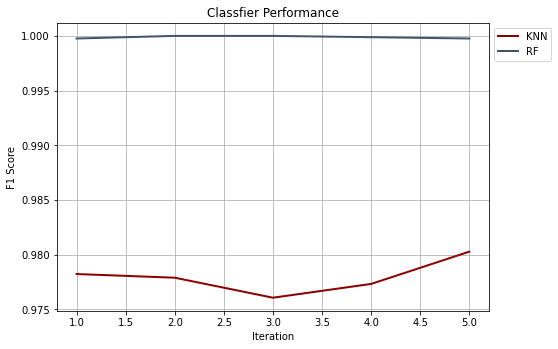

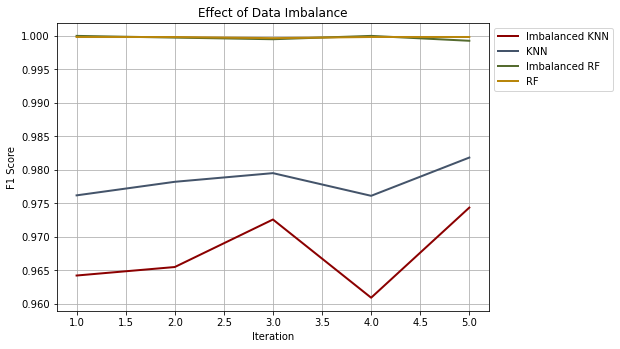

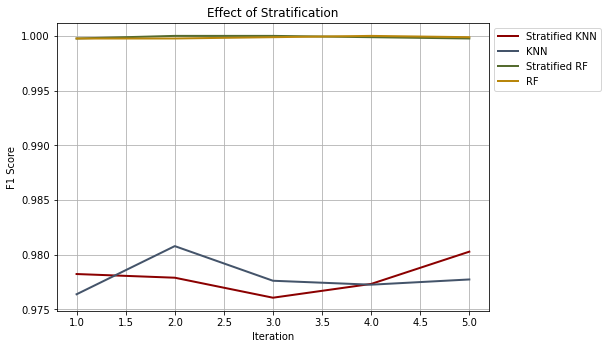

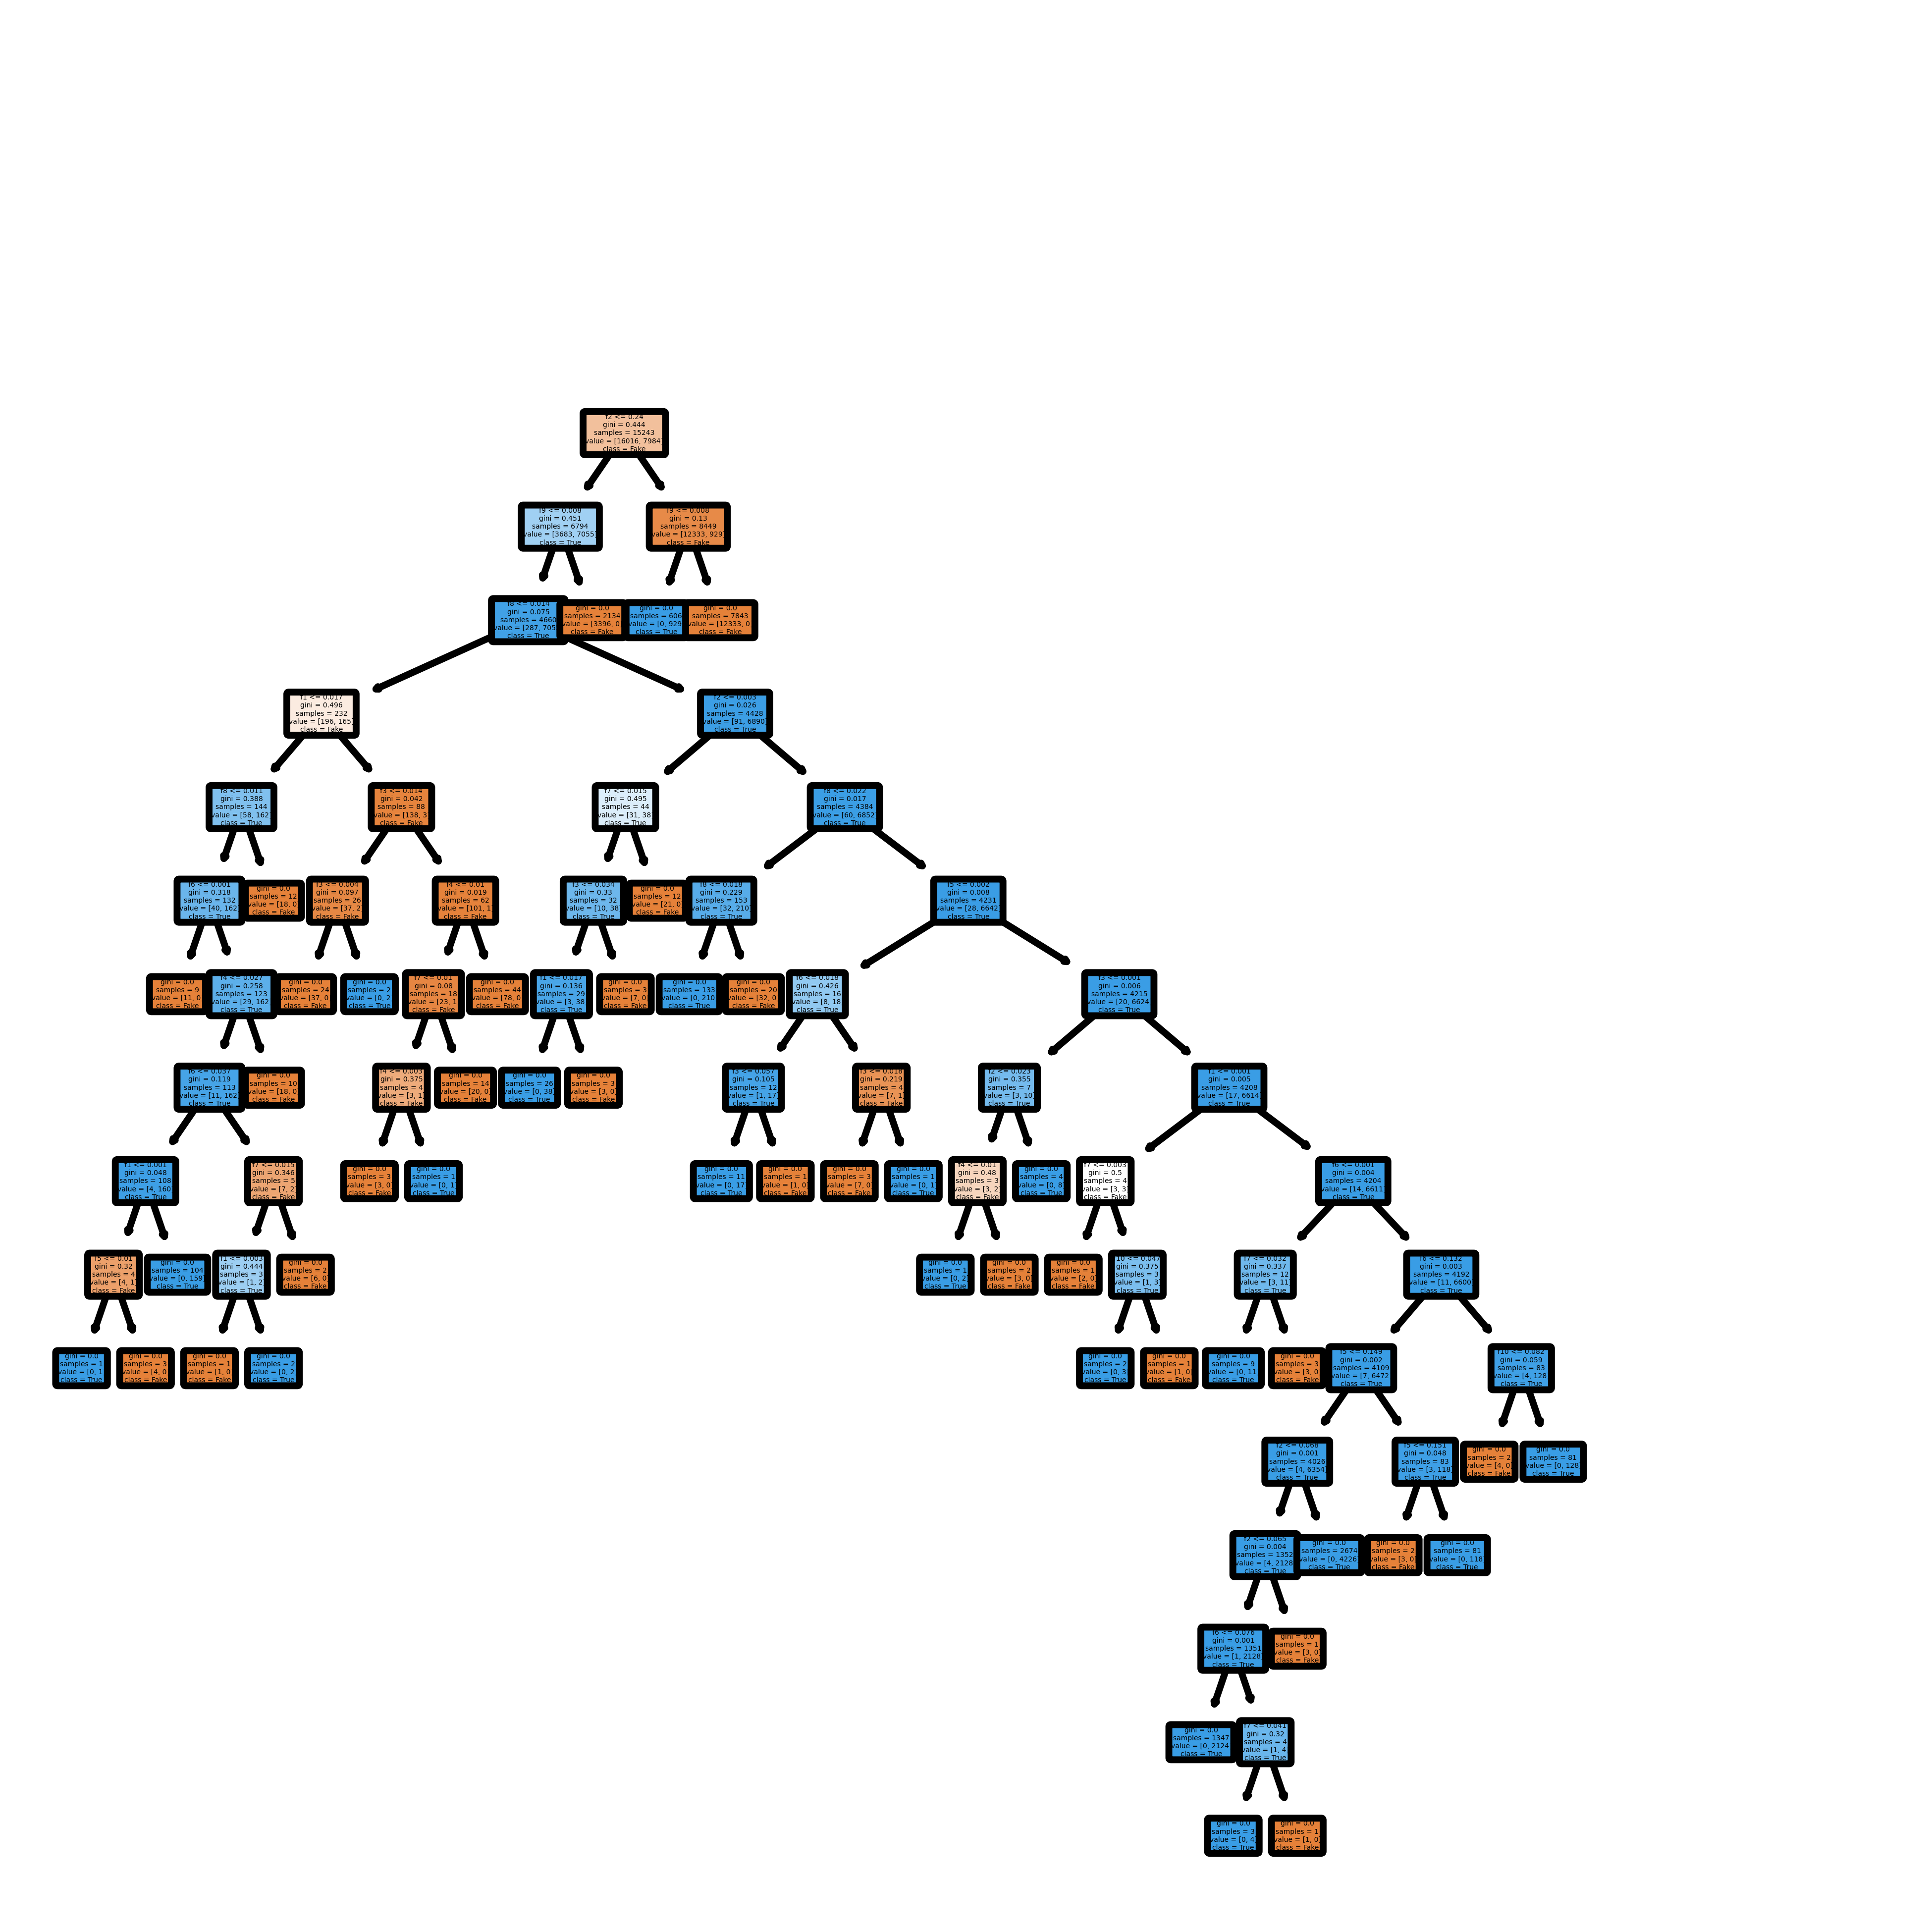

In [92]:
dpi = 300
# Plot visualizing classifier sensitivity to features
# Data is derived from running tests on the Balanced_Sample3
y = [10, 15, 20, 25, 30, 35, 40, 45, 50]
knn_x = [0.99186491956141, 0.983915681661064, 0.978612415730856, 0.971100546536879, 0.965874003556011, 0.951946249464952, 0.942501584979348, 0.918441982272896, 0.870144989111527]
rf_x = [0.999880419964672, 0.999928249690847, 0.999976085136912, 0.999976085136912, 0.999976085136912, 0.999904346265489, 0.999928255410737, 0.999976085136912, 0.999952170273825]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(y, knn_x, color='#556B2F', lw=2)
ax.plot(y, rf_x, color='#B8860B', lw=2)
ax.legend(['KNN', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Average F1 Score')
ax.set_title('Classifier Sensitivity to Features')
plt.grid()
# fig.savefig('../figures/classifier_sensitivity_to_features.png', bbox_inches='tight', dpi=dpi)

# Plot visualizing the performance difference of the classifiers on the Balanced_Sample3
iterations = [1, 2, 3, 4, 5]
knn = [0.9782178217821782, 0.9778812572759022, 0.9760520809114159, 0.9773123909249564, 0.980263926194091]
rf = [0.9997619047619047, 1.0, 1.0, 0.9998809382069294, 0.999761961437753]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(iterations, knn, color='#8B0000', lw=2)
ax.plot(iterations, rf, color='#44546A', lw=2)
ax.legend(['KNN', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Iteration')
ax.set_ylabel('F1 Score')
ax.set_title('Classfier Performance')
plt.grid()
# fig.savefig('../figures/classifier_performance.png', bbox_inches='tight', dpi=dpi)

# Plot visualizing the effect of data Imbalance with 30000 datapoints
iterations = [1, 2, 3, 4, 5]
im_knn = [0.9642156862745099, 0.9654834761321909, 0.972579471002184, 0.9609018949388344, 0.9743589743589743]
ba_knn = [0.9761865659385777, 0.9782106305711455, 0.9795041322314049, 0.9761179676230164, 0.981829876185882]
im_rf = [1.0, 0.999746514575412, 0.9995012468827931, 1.0, 0.9992691839220462]
ba_rf = [0.9998318479905836, 0.999831223628692, 0.9996626180836707, 0.9998358233459202, 0.999836307087903]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(iterations, im_knn, color='#8B0000', lw=2)
ax.plot(iterations, ba_knn, color='#44546A', lw=2)
ax.plot(iterations, im_rf, color='#556B2F', lw=2)
ax.plot(iterations, ba_rf, color='#B8860B', lw=2)
ax.legend(['Imbalanced KNN', 'KNN', 'Imbalanced RF', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Iteration')
ax.set_ylabel('F1 Score')
ax.set_title('Effect of Data Imbalance')
plt.grid()
# fig.savefig('../figures/effect_of_data_imbalance.png', bbox_inches='tight', dpi=dpi)

# Plot visualizing the effect of stratification on the Balanced_Sample3
iterations = [1, 2, 3, 4, 5]
s_knn  = [0.9782178217821782, 0.9778812572759022, 0.9760520809114159, 0.9773123909249564, 0.980263926194091]
ns_knn = [0.9763668430335096, 0.980771471856427, 0.9776033248672361, 0.9772435523398295, 0.9777210489672779]
s_rf = [0.9997619047619047, 1.0, 1.0, 0.9998809382069294, 0.999761961437753]
ns_rf = [0.9997591522157996, 0.9997625267157444, 0.9998818944136056, 1.0, 0.9998813619646458]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(iterations, s_knn, color='#8B0000', lw=2)
ax.plot(iterations, ns_knn, color='#44546A', lw=2)
ax.plot(iterations, s_rf, color='#556B2F', lw=2)
ax.plot(iterations, ns_rf, color='#B8860B', lw=2)
ax.legend(['Stratified KNN', 'KNN', 'Stratified RF', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Iteration')
ax.set_ylabel('F1 Score')
ax.set_title('Effect of Stratification')
plt.grid()
# fig.savefig('../figures/effect_of_stratification.png', bbox_inches='tight', dpi=dpi)

# Plot visualizing a decision tree structure in the random forest from the Balanced_Sample3
fn = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
cn = ['Fake', 'True']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
tree.plot_tree(rfc.estimators_[9], feature_names = fn, class_names=cn, filled = True, rounded=True)
plt.tight_layout()
# fig.savefig('../figures/rf_tree.png')